In [1]:
from joblib import dump, load
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score, classification_report, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay

In [2]:
df = pd.read_csv('../data/PPMI_sncRNAcounts/counts/ML.csv')

In [3]:
task_names = [('PD', 'prodromal'), ('prodromal', 'healthy'), ('PD', 'healthy')]
tasks = [(1, 4), (4, 2), (1, 2)]

In [4]:
def cv_function(X, y, train, test, name, task, fold):
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    temp = {
        'name': name,
        'task': task,
        'fold': fold,
        'model': model,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'accuracy': accuracy,
        'precision': precision,
        'f1': f1
    }
    return temp

In [5]:
cv = StratifiedKFold(n_splits=10)
cv_models = []
futures = []
with ThreadPoolExecutor(max_workers=10) as executor:
    for name, task in zip(task_names, tasks):
        new_df = df[df['COHORT'].isin(task)]
        X = new_df.drop(['PATNO', 'COHORT'], axis=1)
        y = new_df['COHORT']
        for fold, (train, test) in enumerate(cv.split(X, y)):
            futures.append(executor.submit(cv_function, X, y, train, test, name, task, fold))
for future in as_completed(futures):
    cv_models.append(future.result())

In [6]:
dump(cv_models, '../models/gradientboost_cv.joblib')

['../models/gradientboost_cv.joblib']

In [7]:
cv_models = load('../models/gradientboost_cv.joblib')

In [8]:
results = {}
metrics = ['accuracy', 'precision', 'f1']
for obj in cv_models:
    name = obj['name']
    name = '{} vs. {}'.format(name[0], name[1])
    if name not in results:
        results[name] = {}
        for metric in metrics:
            results[name][metric] = []
    for metric in metrics:
        results[name][metric].append(obj[metric])
for name, value in results.items():
    for metric in metrics:
        results[name][metric + '_mean'] = np.mean(value[metric])
        results[name][metric + '_std'] = np.std(value[metric])
cv_df = pd.DataFrame.from_dict(results)
cv_df.drop(metrics, inplace=True)
cv_df.to_csv('../results/manual_cv_results_gradientboost.csv')

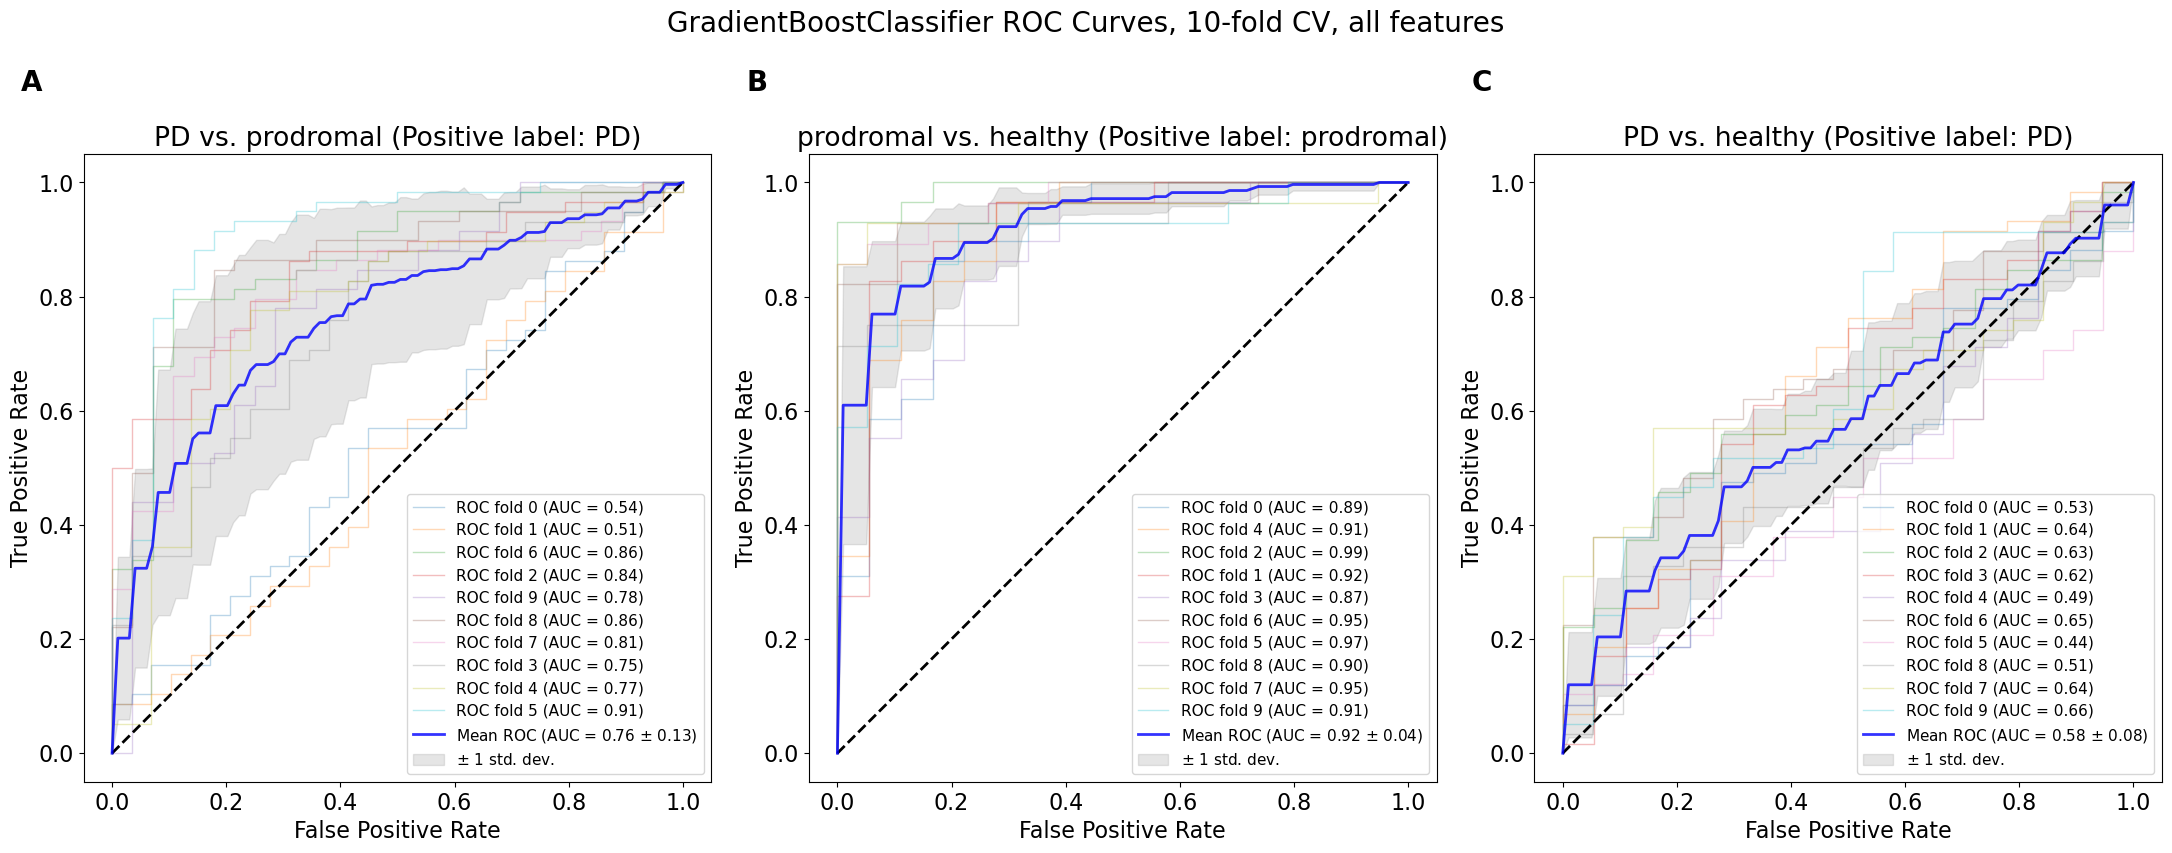

In [9]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

matplotlib.rcParams.update({'font.size': 16})

fig, axes = plt.subplots(1, 3, figsize=(22, 9))
mean_fpr = np.linspace(0, 1, 100)
for name, ax, letter in zip(task_names, axes, ['A', 'B', 'C']):
    tprs = []
    aucs = []
    for obj in cv_models:
        if obj['name'] != name:
            continue
        task = obj['task']
        fold = obj['fold']
        model = obj['model']
        X_test = obj['X_test']
        y_test = obj['y_test']
        vis = RocCurveDisplay.from_estimator(model, X_test, y_test, name=f'ROC fold {fold}',
                                             pos_label=task[0], alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, vis.fpr, vis.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(vis.roc_auc)
    ax.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], xlabel='False Positive Rate',
    ylabel='True Positive Rate', title=f'{name[0]} vs. {name[1]} (Positive label: {name[0]})')
    ax.axis('square')
    ax.legend(loc='lower right', fontsize=11)
    ax.text(-0.1, 1.1, letter, transform=ax.transAxes, size=20, weight='bold')
fig.suptitle('GradientBoostClassifier ROC Curves, 10-fold CV, all features', fontsize=20)
fig.tight_layout()
fig.savefig('../figures/gradientboost_cv_roc_curves.png', dpi=600)
plt.show()